
# Dependencies and Data

In [78]:
!pip install chart-studio
!pip install geopandas
!pip install seaborn
!pip install adjustText
import plotly
import numpy as np
import pandas as pd
import geopandas as gpd
from plotly import tools
import chart_studio.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from geopandas import read_file
import warnings
warnings.filterwarnings("ignore")

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
df1 = pd.read_csv('/content/drive/My Drive/file1.csv')
df2 = pd.read_csv('/content/drive/My Drive/file-2.csv')

# Data Pre-processing

In [83]:
def pre_processing_1(df):

  df = df[['Category','Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'X', 'Y']]
  new_names = {'Category': 'Incident Category', 'Descript': 'Incident Description', 'DayOfWeek': 'Incident Day of Week', 'Date':'Incident Date', 'Time':'Incident Time', 'X':'Longitude', 'Y':'Latitude', 'PdDistrict': 'Police District'}
  df_renamed = df.rename(columns=new_names)
  df_renamed['Incident Date'] = pd.to_datetime(df_renamed['Incident Date'])
  df_renamed['Month'] = df_renamed['Incident Date'].dt.month
  df_renamed['Incident Year'] = df_renamed['Incident Date'].dt.year
  df_renamed['Incident Time'] = pd.to_datetime(df_renamed['Incident Time'])
  df_renamed['Hour'] = df_renamed['Incident Time'].dt.hour
  df_renamed['Incident Date'] = pd.to_datetime(df_renamed['Incident Date'], format='%Y/%m/%d')
  df_renamed['quarter'] = df_renamed['Incident Date'].dt.year.astype(str) + ' ' + 'Q' + df_renamed['Incident Date'].dt.quarter.astype(str)
  df_renamed['Analysis Neighborhood']=''
  df_renamed.dropna(subset=['Police District'], inplace=True)
  df_renamed.loc[df_renamed['Incident Category'] == 'LARCENY/THEFT', 'Incident Category'] = df_renamed.loc[df_renamed['Incident Category'] == 'LARCENY/THEFT', 'Incident Category'].str.replace('/', ' ')
  df_renamed = df_renamed.dropna()
  df_renamed.drop_duplicates(inplace=True)
  mean_latitude = df_renamed['Latitude'].mean()
  df_renamed['Latitude'] = df_renamed['Latitude'].replace(90, mean_latitude)
  mean_longitude = df_renamed['Longitude'].mean()
  df_renamed['Longitude'] = df_renamed['Longitude'].replace(-120.50, mean_longitude)

  def find_closest_neighborhood(lat, lng, data):
    distances = {}
    for neighborhood, (lat_n, lng_n) in data.items():
      distance = ((lat - lat_n)**2 + (lng - lng_n)**2)**0.5
      distances[neighborhood] = distance
    closest_neighborhood = min(distances, key=distances.get)
    return closest_neighborhood

  data = {'Inner Sunset': (37.76145, -122.4676432), 'Haight Ashbury': (37.770028, -122.446982), 'Lincoln Park': (37.78462545, -122.49908597713778), 'Japantown': (37.7855789, -122.4298089), 'North Beach': (37.8011749, -122.4090021), 'Western Addition': (37.779559, -122.42981), 'Bernal Heights': (37.7410008, -122.4142136), 'Mission Bay': (37.7707742, -122.3911712), 'Hayes Valley': (37.7766853, -122.4229361), 'Lakeshore': (37.7330226, -122.49025293956723), 'Bayview Hunters Point': (37.73187395, -122.38973399151861), 'Visitacion Valley': (37.7121319, -122.4097128), 'Nob Hill': (37.7932622, -122.415249), 'Treasure Island': (37.82380605, -122.37041062623358), 'Chinatown': (37.7943011, -122.4063757), 'Mission': (37.7524984, -122.4128258), 'Excelsior': (37.7217943, -122.4353815), 'Twin Peaks': (37.75464, -122.44648), 'Seacliff': (37.7885406, -122.4869164), 'Presidio Heights': (37.7887511, -122.4530266), 'Portola': (37.726379, -122.4085514), 'Golden Gate Park': (37.769368099999994, -122.48218371117709), 'Glen Park': (37.734281, -122.4344696), 'McLaren Park': (37.717454200000006, -122.41754187807015), 'Presidio': (37.798745600000004, -122.46458892410745), 'Potrero Hill': (37.759652, -122.3980262), 'Tenderloin': (37.7842493, -122.4139933), 'Outer Mission': (37.7452716, -122.4199359), 'Marina': (37.7997929, -122.435204), 'Noe Valley': (37.7515906, -122.4320814), 'Russian Hill': (37.8000729, -122.417094), 'South of Market': (37.7808925, -122.4009518), 'Pacific Heights': (37.7927171, -122.4356445)}
  df_renamed['Analysis Neighborhood'] = df_renamed.apply(lambda row: find_closest_neighborhood(row['Latitude'], row['Longitude'], data), axis=1)
  filtered_df = df_renamed[(df_renamed['Incident Year'] > 2012) & (df_renamed['Incident Year'] <= 2017)]
  return filtered_df
updated_df_1 = pre_processing_1(df1)

In [84]:
updated_df_1

,Incident Category,Incident Description,Incident Day of Week,Incident Date,Incident Time,Police District,Longitude,Latitude,Month,Incident Year,Hour,quarter,Analysis Neighborhood
5,ASSAULT,BATTERY,Tuesday,2013-04-02,2024-03-25 15:50:00,TARAVAL,-122.470366,37.745158,4,2013,15,2013 Q2,Inner Sunset
6,ASSAULT,BATTERY,Sunday,2017-08-06,2024-03-25 18:15:00,SOUTHERN,-122.403405,37.775421,8,2017,18,2017 Q3,South of Market
7,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,Thursday,2016-03-03,2024-03-25 19:30:00,TARAVAL,-122.463545,37.707968,3,2016,19,2016 Q1,Excelsior
35,LARCENY THEFT,PETTY THEFT OF PROPERTY,Wednesday,2013-09-11,2024-03-25 16:00:00,CENTRAL,-122.398217,37.793487,9,2013,16,2013 Q3,Chinatown
36,ASSAULT,AGGRAVATED ASSAULT WITH A GUN,Sunday,2013-06-30,2024-03-25 20:27:00,TENDERLOIN,-122.413679,37.780926,6,2013,20,2013 Q2,Tenderloin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2129520,DRUG/NARCOTIC,POSSESSION OF NARCOTICS PARAPHERNALIA,Thursday,2017-06-22,2024-03-25 01:42:00,CENTRAL,-122.398699,37.798880,6,2017,1,2017 Q2,Chinatown
2129521,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,2017-09-01,2024-03-25 17:00:00,PARK,-122.443312,37.770470,9,2017,17,2017 Q3,Haight Ashbury
2129522,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Friday,2017-06-30,2024-03-25 17:50:00,BAYVIEW,-122.387068,37.755446,6,2017,17,2017 Q2,Potrero Hill
2129523,OTHER OFFENSES,PEDDLING WITHOUT A LICENSE,Wednesday,2017-12-20,2024-03-25 15:41:00,SOUTHERN,-122.412515,37.780478,12,2017,15,2017 Q4,Tenderloin


In [86]:
def pre_processing_2(df):
    def imputing_LatLong(df):
        grouped_by_district = df.groupby('Police District')
        imputed_df = grouped_by_district[['Latitude', 'Longitude']].transform(lambda x: x.fillna(x.mean()))
        df[['Latitude', 'Longitude']] = imputed_df
        return df

    def imputing_Cat(df):
        mode_value = df['Incident Category'].mode()[0]  # Get the first mode (if multiple)
        df['Incident Category'] = df['Incident Category'].fillna(mode_value)
        return df

    def imputing_subCat(df):
        grouped_by_district = df.groupby('Incident Category')
        imputed_df = grouped_by_district['Incident Subcategory'].transform(lambda x: x.fillna(x.mode()[0]))
        df['Incident Subcategory'] = imputed_df
        return df

    def imputing_hood(df):
        grouped_by_district = df.groupby('Police District')
        imputed_df = grouped_by_district['Analysis Neighborhood'].transform(lambda x: x.fillna(x.mode()[0]))
        df['Analysis Neighborhood'] = imputed_df
        return df

    def imputing_hood(df):

      def impute_with_mode(x):
        # Fill with mode, replacing both NaN and "null" with the mode
        return x.fillna(x.mode()[0]).replace("null", x.mode()[0])

      grouped_by_district = df.groupby('Police District')
      imputed_df = grouped_by_district['Analysis Neighborhood'].transform(impute_with_mode)
      df['Analysis Neighborhood'] = imputed_df
      return df

    imputing_LatLong(df)
    imputing_Cat(df)
    imputing_subCat(df)
    imputing_hood(df)
    imputing_hood(df)
    df["Incident Category"] = df["Incident Category"].str.upper()
    df["Police District"] = df["Police District"].str.upper()
    df["Incident Description"] = df["Incident Description"].str.upper()
    df = df[['Incident Category', 'Incident Description', 'Incident Day of Week', 'Incident Date', 'Incident Time', 'Police District', 'Longitude', 'Latitude', 'Incident Year','Analysis Neighborhood' ]]
    df['Incident Date'] = pd.to_datetime(df['Incident Date'], format='%Y/%m/%d')
    df['quarter'] = df['Incident Date'].dt.year.astype(str) + ' ' + 'Q' + df['Incident Date'].dt.quarter.astype(str)
    df['Month'] = df['Incident Date'].dt.month
    df['Incident Time'] = pd.to_datetime(df['Incident Time'])
    df['Hour'] = df['Incident Time'].dt.hour
    df.drop_duplicates(inplace=True)
    filtered_df = df[(df['Incident Year'] < 2024)]
    return filtered_df
updated_df_2 = pre_processing_2(df2)

In [87]:
updated_df_2

,Incident Category,Incident Description,Incident Day of Week,Incident Date,Incident Time,Police District,Longitude,Latitude,Incident Year,Analysis Neighborhood,quarter,Month,Hour
0,RECOVERED VEHICLE,"VEHICLE, RECOVERED, AUTO",Monday,2023-03-13,2024-03-25 23:41:00,OUT OF SF,-122.414016,37.770825,2023,Mission Bay,2023 Q1,3,23
1,LARCENY THEFT,"THEFT, OTHER PROPERTY, >$950",Wednesday,2023-03-01,2024-03-25 05:02:00,MISSION,-122.420408,37.760096,2023,Mission,2023 Q1,3,5
2,RECOVERED VEHICLE,"VEHICLE, RECOVERED, AUTO",Monday,2023-03-13,2024-03-25 13:16:00,OUT OF SF,-122.414016,37.770825,2023,Mission Bay,2023 Q1,3,13
3,RECOVERED VEHICLE,"VEHICLE, RECOVERED, AUTO",Monday,2023-03-13,2024-03-25 10:59:00,OUT OF SF,-122.414016,37.770825,2023,Mission Bay,2023 Q1,3,10
4,RECOVERED VEHICLE,"VEHICLE, RECOVERED, AUTO",Tuesday,2023-03-14,2024-03-25 18:44:00,OUT OF SF,-122.414016,37.770825,2023,Mission Bay,2023 Q1,3,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833849,WARRANT,"WARRANT ARREST, ENROUTE TO OUTSIDE JURISDICTION",Wednesday,2023-03-22,2024-03-25 17:35:00,MISSION,-122.419018,37.752204,2023,Mission,2023 Q1,3,17
833850,LARCENY THEFT,"THEFT, FROM LOCKED VEHICLE, >$950",Monday,2023-03-06,2024-03-25 16:41:00,CENTRAL,-122.422007,37.805497,2023,Russian Hill,2023 Q1,3,16
833853,LARCENY THEFT,"THEFT, OTHER PROPERTY, <$50",Wednesday,2023-03-22,2024-03-25 00:13:00,NORTHERN,-122.440624,37.788995,2023,Pacific Heights,2023 Q1,3,0
833854,NON-CRIMINAL,FOUND PROPERTY,Tuesday,2023-03-21,2024-03-25 21:19:00,INGLESIDE,-122.452665,37.708806,2023,Outer Mission,2023 Q1,3,21


In [88]:
concatenated_df = pd.concat([updated_df_1, updated_df_2])
# concatenated_df = temp_df[(temp_df['Incident Year'] > 2012) & (temp_df['Incident Year'] < 2024)]

In [89]:
concatenated_df

,Incident Category,Incident Description,Incident Day of Week,Incident Date,Incident Time,Police District,Longitude,Latitude,Month,Incident Year,Hour,quarter,Analysis Neighborhood
5,ASSAULT,BATTERY,Tuesday,2013-04-02,2024-03-25 15:50:00,TARAVAL,-122.470366,37.745158,4,2013,15,2013 Q2,Inner Sunset
6,ASSAULT,BATTERY,Sunday,2017-08-06,2024-03-25 18:15:00,SOUTHERN,-122.403405,37.775421,8,2017,18,2017 Q3,South of Market
7,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,Thursday,2016-03-03,2024-03-25 19:30:00,TARAVAL,-122.463545,37.707968,3,2016,19,2016 Q1,Excelsior
35,LARCENY THEFT,PETTY THEFT OF PROPERTY,Wednesday,2013-09-11,2024-03-25 16:00:00,CENTRAL,-122.398217,37.793487,9,2013,16,2013 Q3,Chinatown
36,ASSAULT,AGGRAVATED ASSAULT WITH A GUN,Sunday,2013-06-30,2024-03-25 20:27:00,TENDERLOIN,-122.413679,37.780926,6,2013,20,2013 Q2,Tenderloin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833849,WARRANT,"WARRANT ARREST, ENROUTE TO OUTSIDE JURISDICTION",Wednesday,2023-03-22,2024-03-25 17:35:00,MISSION,-122.419018,37.752204,3,2023,17,2023 Q1,Mission
833850,LARCENY THEFT,"THEFT, FROM LOCKED VEHICLE, >$950",Monday,2023-03-06,2024-03-25 16:41:00,CENTRAL,-122.422007,37.805497,3,2023,16,2023 Q1,Russian Hill
833853,LARCENY THEFT,"THEFT, OTHER PROPERTY, <$50",Wednesday,2023-03-22,2024-03-25 00:13:00,NORTHERN,-122.440624,37.788995,3,2023,0,2023 Q1,Pacific Heights
833854,NON-CRIMINAL,FOUND PROPERTY,Tuesday,2023-03-21,2024-03-25 21:19:00,INGLESIDE,-122.452665,37.708806,3,2023,21,2023 Q1,Outer Mission


In [90]:
concatenated_df.isnull().sum()

Incident Category        0
Incident Description     0
Incident Day of Week     0
Incident Date            0
Incident Time            0
Police District          0
Longitude                0
Latitude                 0
Month                    0
Incident Year            0
Hour                     0
quarter                  0
Analysis Neighborhood    0
dtype: int64

# Visualization

### Total Number of Crimes per Time
The line plot illustrates the total number of crimes over time in San Francisco. There seem to be some fluctuations and potentially some trends or patterns that could be worth exploring further. As one can see, there is a major dip during the start of the pandemic

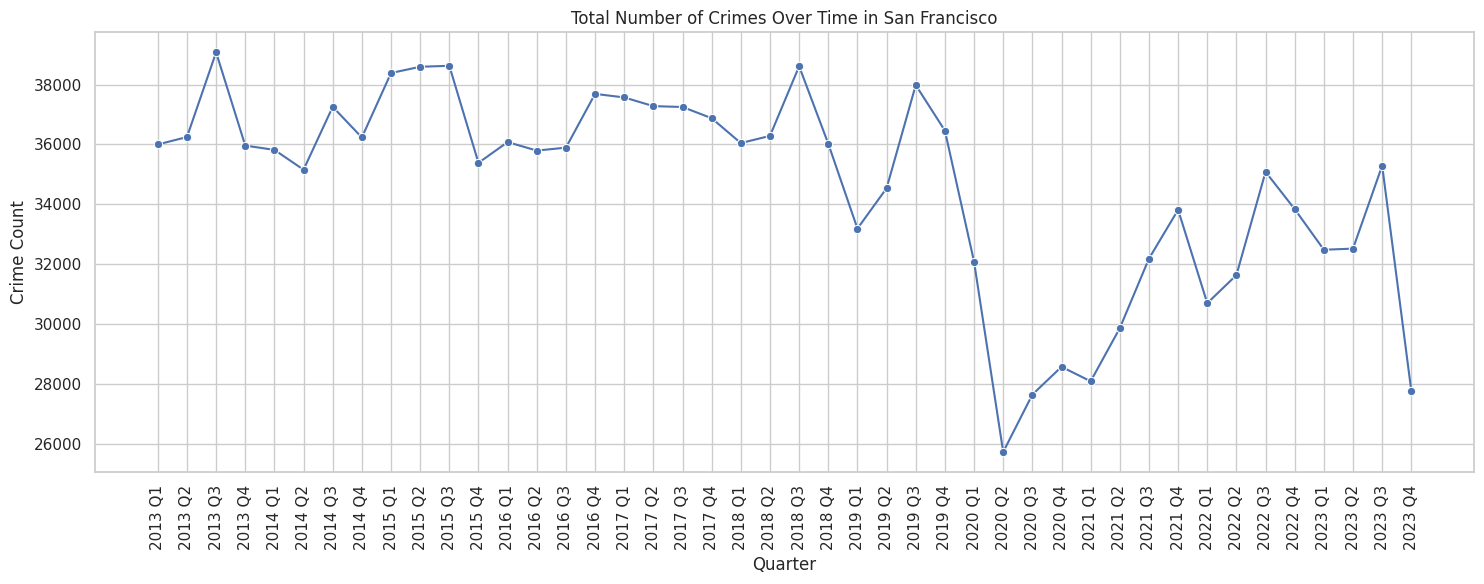

In [91]:
crime_over_time = concatenated_df['quarter'].value_counts().sort_index().reset_index()
crime_over_time.columns = ['quarter', 'Crime Count']
crime_over_time = crime_over_time[crime_over_time['quarter'] >= '2013 Q1']
plt.figure(figsize=(15, 6))
sns.lineplot(x='quarter', y='Crime Count', data=crime_over_time, marker='o', color='b')
plt.title('Total Number of Crimes Over Time in San Francisco')
plt.xlabel('Quarter')
plt.ylabel('Crime Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Frequency of Top 10 Crime Types by Area in San Francisco
The heatmap provides a detailed view of how the top 10 crime types are distributed across different areas in San Francisco. The color intensity indicates the frequency of each crime type within an area, allowing us to quickly identify which crimes are most prevalent in which areas. This kind of visualization can be particularly useful for law enforcement to target specific crime types in areas where they are most common.

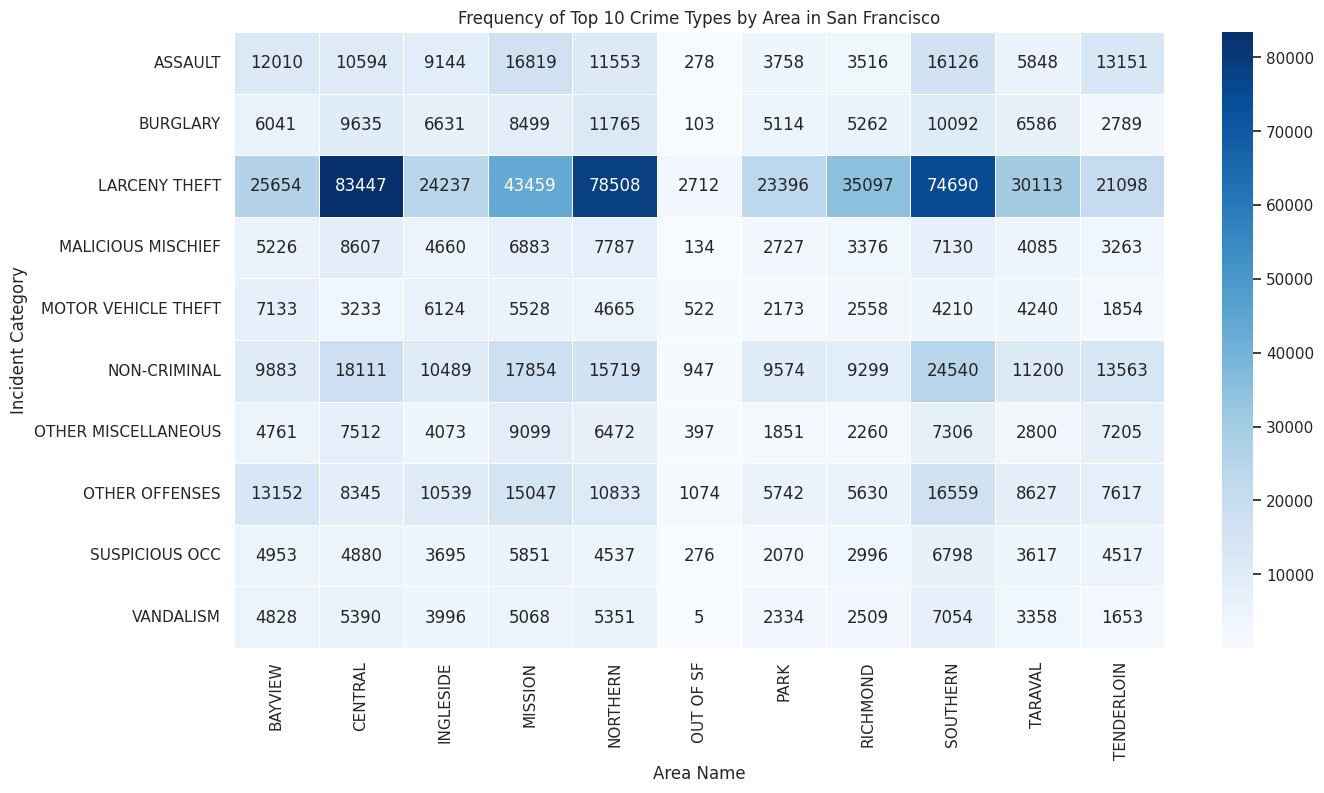

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
crime_type_counts = concatenated_df['Incident Category'].value_counts().nlargest(10).reset_index()
crime_type_counts.columns = ['Police District', 'Count']
top_crimes = crime_type_counts['Police District'].tolist()
top_crimes_data = concatenated_df[concatenated_df['Incident Category'].isin(top_crimes)]
crime_type_area_pivot = top_crimes_data.pivot_table(index='Incident Category', columns='Police District', aggfunc='size', fill_value=0)
plt.figure(figsize=(15, 8))
sns.heatmap(crime_type_area_pivot, annot=True, fmt="d", cmap='Blues', linewidths=.5)
plt.title('Frequency of Top 10 Crime Types by Area in San Francisco')
plt.xlabel('Area Name')
plt.ylabel('Incident Category')
plt.xticks(rotation=90)
plt.show()

### Top 10 Most Common Crime Types in San Francisco
This visualization provides a clear picture of which types of crimes are most frequently reported. Understanding the prevalence of different crime types can help in prioritizing and strategizing crime prevention and response efforts.

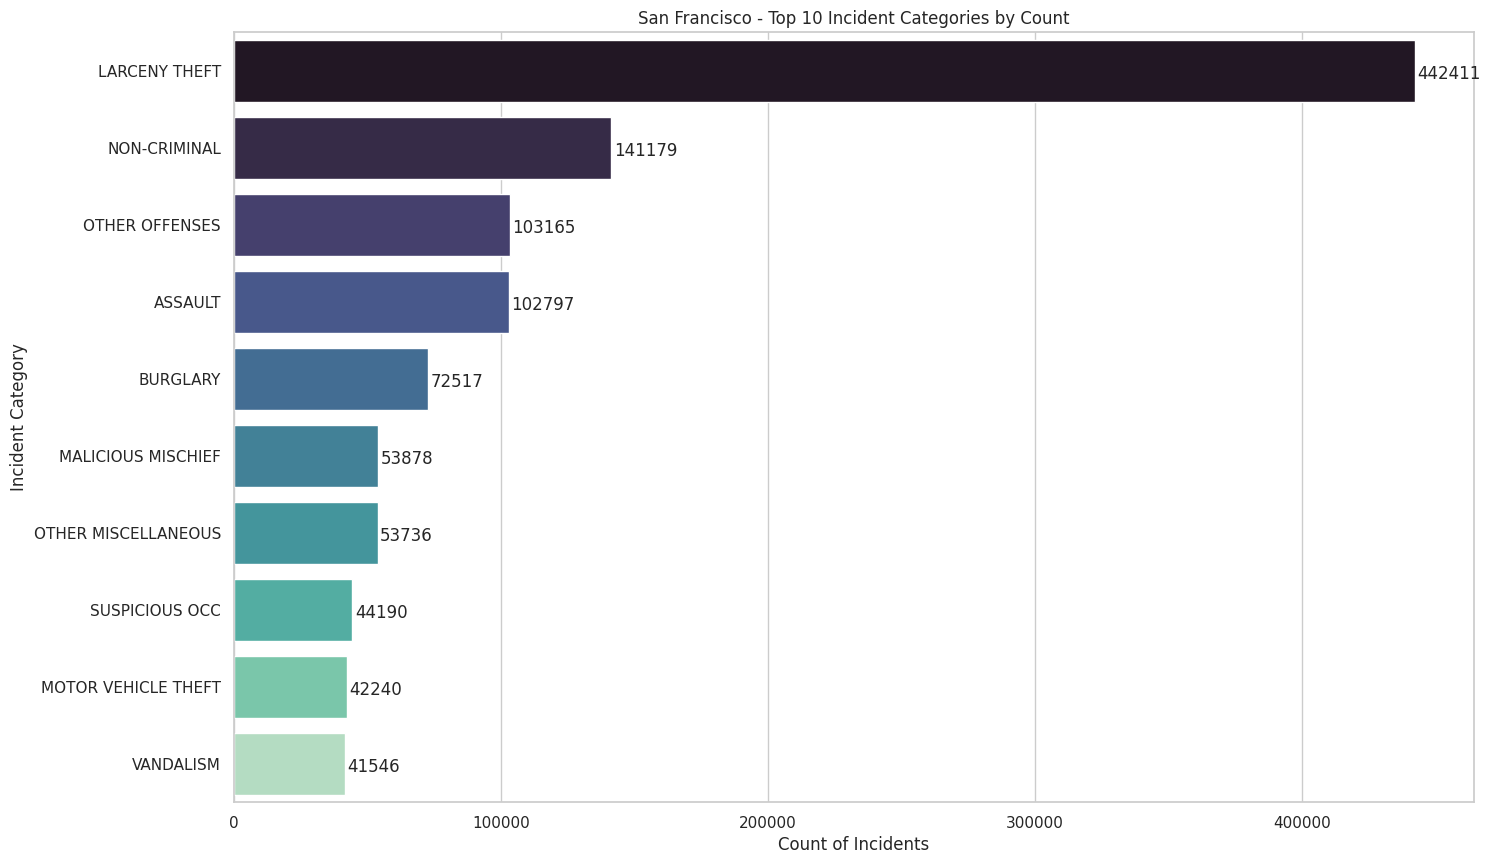

In [93]:
cat_count = concatenated_df['Incident Category'].value_counts()
cat_count_df = pd.DataFrame(cat_count)
cat_count_df.reset_index(inplace=True)
cat_count_df.columns = ['Incident Category', 'Count']
top_10_categories = cat_count_df.nlargest(10, 'Count')
plt.figure(figsize=(16, 10))
g = sns.barplot(x="Count", y="Incident Category", data=top_10_categories, palette="mako")
for i, p in enumerate(g.patches):
    g.text(p.get_width() + 1000, p.get_y() + 0.5, top_10_categories['Count'].iloc[i])
plt.title('San Francisco - Top 10 Incident Categories by Count')
plt.xlabel('Count of Incidents')
plt.ylabel('Incident Category')
plt.show()

### Trends of Top 10 Crime Types Over Time in San Francisco
The line plot illustrates the trends of the top 10 crime types over time in San Francisco. Each line represents the frequency of a specific crime type from month to month. This visualization helps us identify patterns, such as increases or decreases in crime rates, and any seasonal trends or anomalies.

From the plot, we can observe that some crime types show clear trends, while others fluctuate more randomly. This kind of analysis can be particularly insightful for predicting future crime rates and understanding the effectiveness of law enforcement strategies over time.

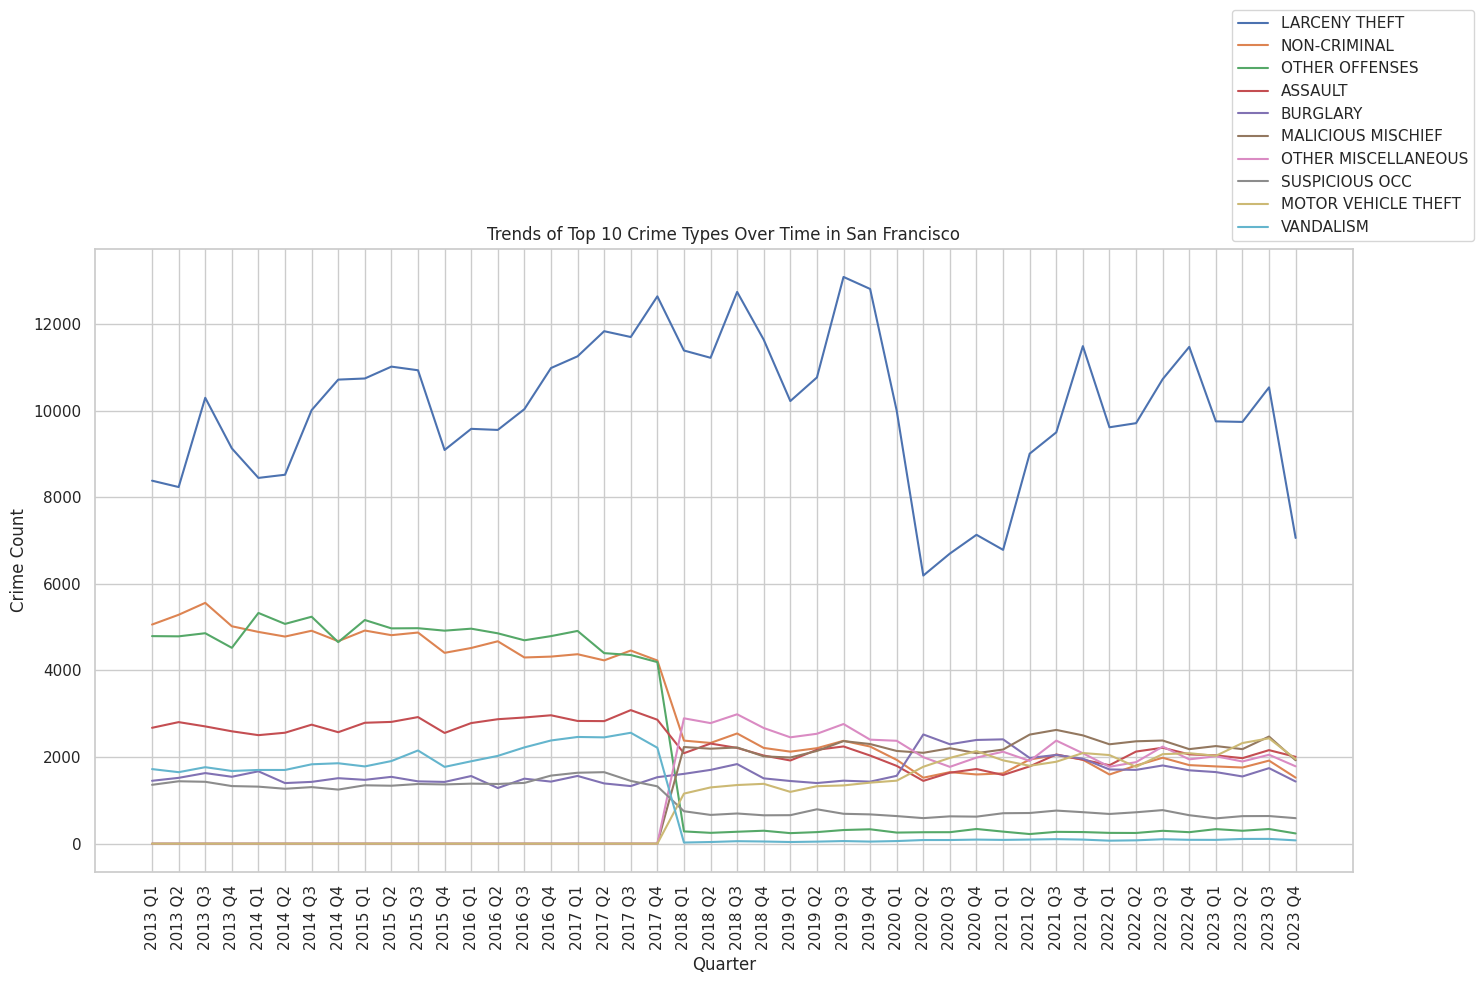

In [94]:
top_crimes_time_data = concatenated_df.groupby(['quarter', 'Incident Category']).size().unstack(fill_value=0)
top_crimes_time_data = top_crimes_time_data[top_crimes_time_data.index > '2012 Q4']
plt.figure(figsize=(15, 10))
sns.set(style="whitegrid")
for crime in top_crimes:
    sns.lineplot(x=top_crimes_time_data.index, y=top_crimes_time_data[crime], label=crime)
plt.title('Trends of Top 10 Crime Types Over Time in San Francisco')
plt.xlabel('Quarter')
plt.ylabel('Crime Count')
plt.xticks(rotation=90)
plt.legend(loc='lower center', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

### Mapping Crimes by Area in San Francisco
The areas with the highest crime rates are concentrated in the Tenderloin, South of Market, and Bayview Hunters Point neighborhoods. These areas are dark colors on the map.
Crime rates appear to be lower in the western and northern parts of the city, such as Lincoln Park, Presidio Heights, and Seacliff. These areas are colored light yellow or beige on the map.
It is important to note that this heatmap only provides a general overview of crime rates in San Francisco. Other factors, such as the type of crime, can also be important to consider.

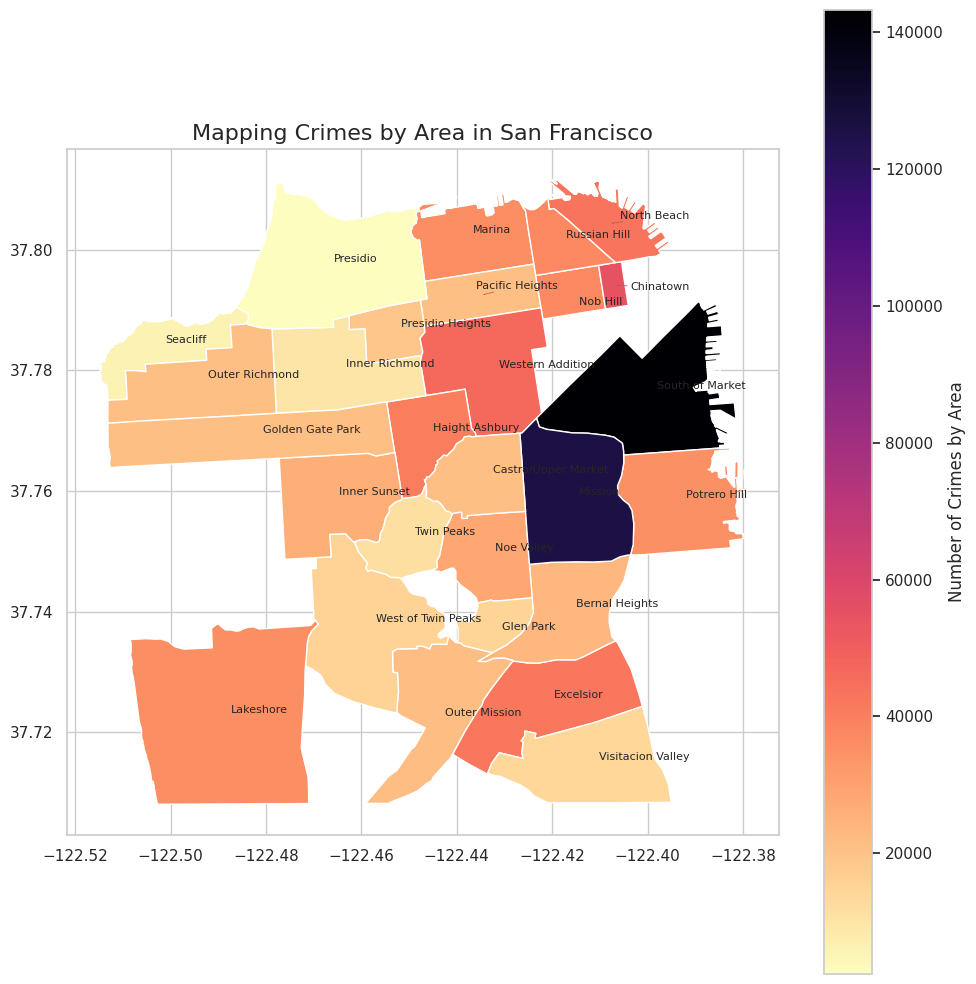

In [95]:
crime_counts = concatenated_df.groupby('Analysis Neighborhood').size().reset_index(name='crime_count')
gdf = read_file("/content/drive/My Drive/san-francisco-ca_.geojson")
gdf_merged = gdf.merge(crime_counts, left_on='name', right_on='Analysis Neighborhood')
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")
gdf_merged.plot(column='crime_count', ax=ax, legend=True, cmap='magma_r',
                legend_kwds={'label': "Number of Crimes by Area"})
texts = []
for x, y, label in zip(gdf_merged.geometry.centroid.x, gdf_merged.geometry.centroid.y, gdf_merged['name']):
    texts.append(ax.text(x, y, label, fontsize=8))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
plt.title('Mapping Crimes by Area in San Francisco', fontsize=16)
plt.tight_layout()
plt.show()

### Number of Crimes by Day of the Week
The chart shows the "Number of Crimes by Day of the Week." Crimes are fairly consistent daily, with slight peaks on Friday and a modest dip on Sunday. This uniformity suggests crimes occur regularly, irrespective of the day. Further investigation might reveal factors influencing this near-even distribution.

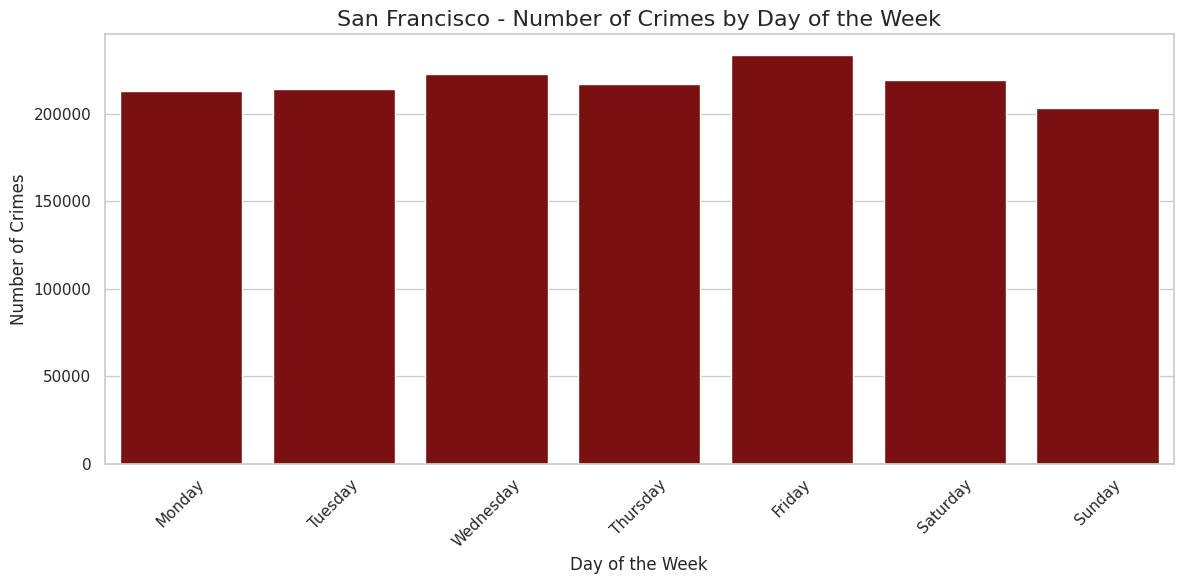

In [96]:
weekday_counts = concatenated_df.groupby('Incident Day of Week').size().reset_index(name='crime_count')
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.set_index('Incident Day of Week').loc[order].reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Incident Day of Week', y='crime_count', data=weekday_counts, color= 'darkred', order= order)
plt.title('San Francisco - Number of Crimes by Day of the Week', fontsize=16)
plt.ylabel('Number of Crimes')
plt.xlabel('Day of the Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Distribution of Crimes by Hour of the Day
The chart depicts "Distribution of Crimes by Hour of the Day." Crime occurrences dip in the early hours, rise steadily through the morning, peak around midday, then maintain a high plateau in the afternoon and evening.

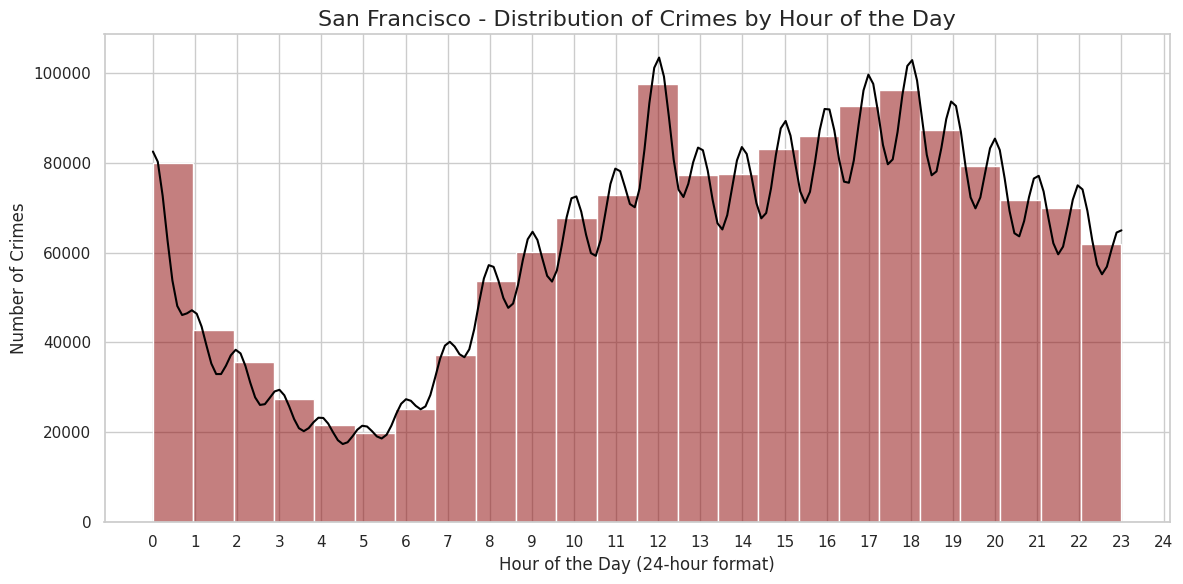

In [97]:
plt.figure(figsize=(12, 6))
sns.histplot(concatenated_df['Hour'], bins=24, kde=True, color='darkred').lines[0].set_color('black')
plt.title('San Francisco - Distribution of Crimes by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day (24-hour format)')
plt.ylabel('Number of Crimes')
plt.xticks(range(0, 25))
plt.tight_layout()
plt.show()